In [1]:
# Notebook to compare basic meteorological parameters between WRF simulations and ERA5 data
# Some of the following imports are not used right now, but will retain for future flexibility
#import sys
#!{sys.executable} -m pip install geopandas
 
import os
import geopandas as gpd
from shapely.geometry import Point
import csv
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib.font_manager import FontProperties
import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pygrib
import pyproj
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata
from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
import glob

In [2]:
directory_path = '/scratch/sawyer/stage_IV_storm_tot/2017-01-09/72h_total'

all_files = os.listdir(directory_path)
storm_total = np.zeros((881, 1121))
for file in all_files:
    file_path = os.path.join(directory_path, file)
    
    with pygrib.open(file_path) as grb:
        # Assuming the first message contains the precipitation data
        # Adjust as necessary based on the structure of your GRIB files
        message = grb.message(1)
        #print(message)
        data = message.values
        #print(data.shape)
        # Extract latitudes and longitudes
        stageiv_lats, stageiv_lons = message.latlons()

        storm_total += data

In [3]:
print(stageiv_lats.max(),stageiv_lons.min())
print(stageiv_lats.min(),stageiv_lons.max())
new_lons =np.where(stageiv_lons > 0, stageiv_lons - 360, stageiv_lons)
print(stageiv_lats.max(),new_lons.min())
print(stageiv_lats.min(),new_lons.max())

57.86960587502908 -134.06060850682636
19.7953341373756 -59.90439862397843
57.86960587502908 -134.06060850682636
19.7953341373756 -59.90439862397843


In [4]:
prism ='/scratch/sawyer/2017_01_09/prism_2017_01_07.nc'
files = (glob.glob(prism))
file = Dataset(files[0])
# Extract data
plats = file.variables['lat'][:] 
# assuming the latitude variable is named 'latitude'
plons = file.variables['lon'][:]
precip = file.variables['Band1'][:]
print(plats.shape, plons.shape, precip.shape)
lon_prism, lat_prism = np.meshgrid(plons, plats)

# Prepare files for processing
prism_data = '/scratch/sawyer/2017_01_09/prism*'
datafiles = (glob.glob(prism_data))
datafiles.sort()
numfiles=len(datafiles)
print(datafiles)
#Add PRISM Storm Total
prism_storm_total = np.zeros(precip.shape)
for i in range(0,numfiles):

    ncfile = Dataset(datafiles[i])
    precip = ncfile.variables['Band1'][:]  # assuming the precipitation variable is named 'precip'
    # Add current precipitation data to total_precip
    prism_storm_total += precip

(621,) (1405,) (621, 1405)
['/scratch/sawyer/2017_01_09/prism_2017_01_07.nc', '/scratch/sawyer/2017_01_09/prism_2017_01_08.nc', '/scratch/sawyer/2017_01_09/prism_2017_01_09.nc']


In [5]:
# Define the source CRS (your PRISM data's original projection)
target_proj = pyproj.Proj(proj='latlong', datum='NAD83', ellps='GRS80')


# Define the source CRS for Stage IV using polar stereographic parameters
# You might need to adjust the parameters (central_longitude, central_latitude, etc.) to match the exact definition of the Stage IV projection.
#source_proj = pyproj.Proj("proj=stere +lat_0=90 +lat_ts=60 +lon_0=105 +x_0=0 +y_0=0 +a=6371200 +b=6371200 +units=m +no_defs")
source_proj = pyproj.Proj(proj = 'latlong', datum= 'NAD83', ellps='GRS80')

# Transform the Stage IV coordinates
lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,stageiv_lats) 
#print(lon_new)
print("Reprojected Stage IV Lon bounds:", lon_new.min(), "-", lon_new.max())
print("PRISM Lon bounds:", lon_prism.min(), "-", lon_prism.max())
print("Reprojected Stage IV Lat bounds:", lat_new.min(), "-", lat_new.max())
print("PRISM Lat bounds:", lat_prism.min(), "-", lat_prism.max())

# Assuming stageiv_lons and stageiv_lats are the 2D arrays representing the longitude and latitude grids of your WRF data.
points_stageiv = (lon_new.ravel(), lat_new.ravel()) 

values_stageiv = to_np(storm_total).ravel()  # PRISM data values
#print(values_stageiv)
stageiv_data = griddata(points_stageiv, values_stageiv, (lon_prism, lat_prism), method='linear')


Reprojected Stage IV Lon bounds: -134.06060850682636 - -59.90439862397843
PRISM Lon bounds: -125.0 - -66.4999999999532
Reprojected Stage IV Lat bounds: 19.7953341373756 - 57.86960587502908
PRISM Lat bounds: 24.083333333312403 - 49.9166666666664


/tmp/ipykernel_45714/907302700.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,stageiv_lats)


In [6]:
'''
plt.scatter(lon_new.ravel(), lat_new.ravel(), s=1, c='blue', label='Reprojected Stage IV')
plt.scatter(lon_prism.ravel(), lat_prism.ravel(), s=1, c='red', label='PRISM', alpha=0.5)
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Overlap Inspection')
plt.show()
'''

"\nplt.scatter(lon_new.ravel(), lat_new.ravel(), s=1, c='blue', label='Reprojected Stage IV')\nplt.scatter(lon_prism.ravel(), lat_prism.ravel(), s=1, c='red', label='PRISM', alpha=0.5)\nplt.legend()\nplt.xlabel('Longitude')\nplt.ylabel('Latitude')\nplt.title('Overlap Inspection')\nplt.show()\n"

In [7]:
#print(np.nanmax(data_wrf))

In [8]:
# Check if all values are NaN
#all_nan = np.all(np.isnan(data_wrf))

#print("All values are NaN:", all_nan)

Text(0.5, 1.0, 'Stage IV 72 h Storm Total')

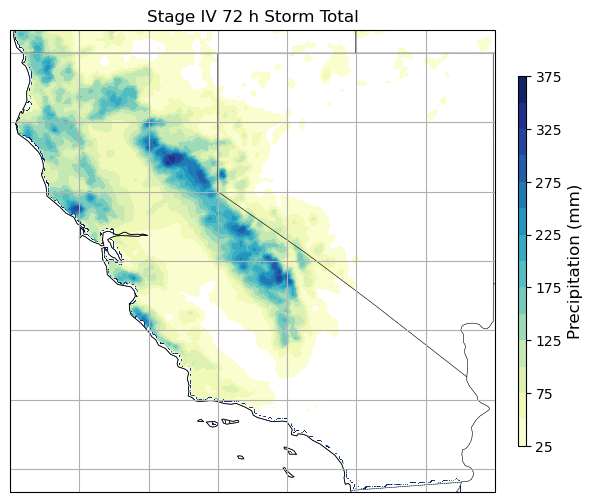

In [11]:
# Set limits for latitude and longitude to focus on California
# Rough bounds: (32.5 to 42 N) and (-124.5 to -114 W)
lat_min, lat_max = 32.5, 42.5
lon_min, lon_max = -124.5, -114

fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='black')
ax.coastlines('50m', linewidth=0.6, color='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False # suppress top labels
gl.bottom_labels=False
gl.right_labels=False 
gl.left_labels=False

contours = plt.contourf(to_np(lon_prism), to_np(lat_prism), stageiv_data, cmap='YlGnBu', levels=np.arange(25, 400, 25), transform=ccrs.PlateCarree())
cbar = plt.colorbar(contours, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
cbar.set_label("Precipitation (mm)", fontsize = 12)
ax.set_title("Stage IV 72 h Storm Total")


/tmp/ipykernel_45714/2720304215.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


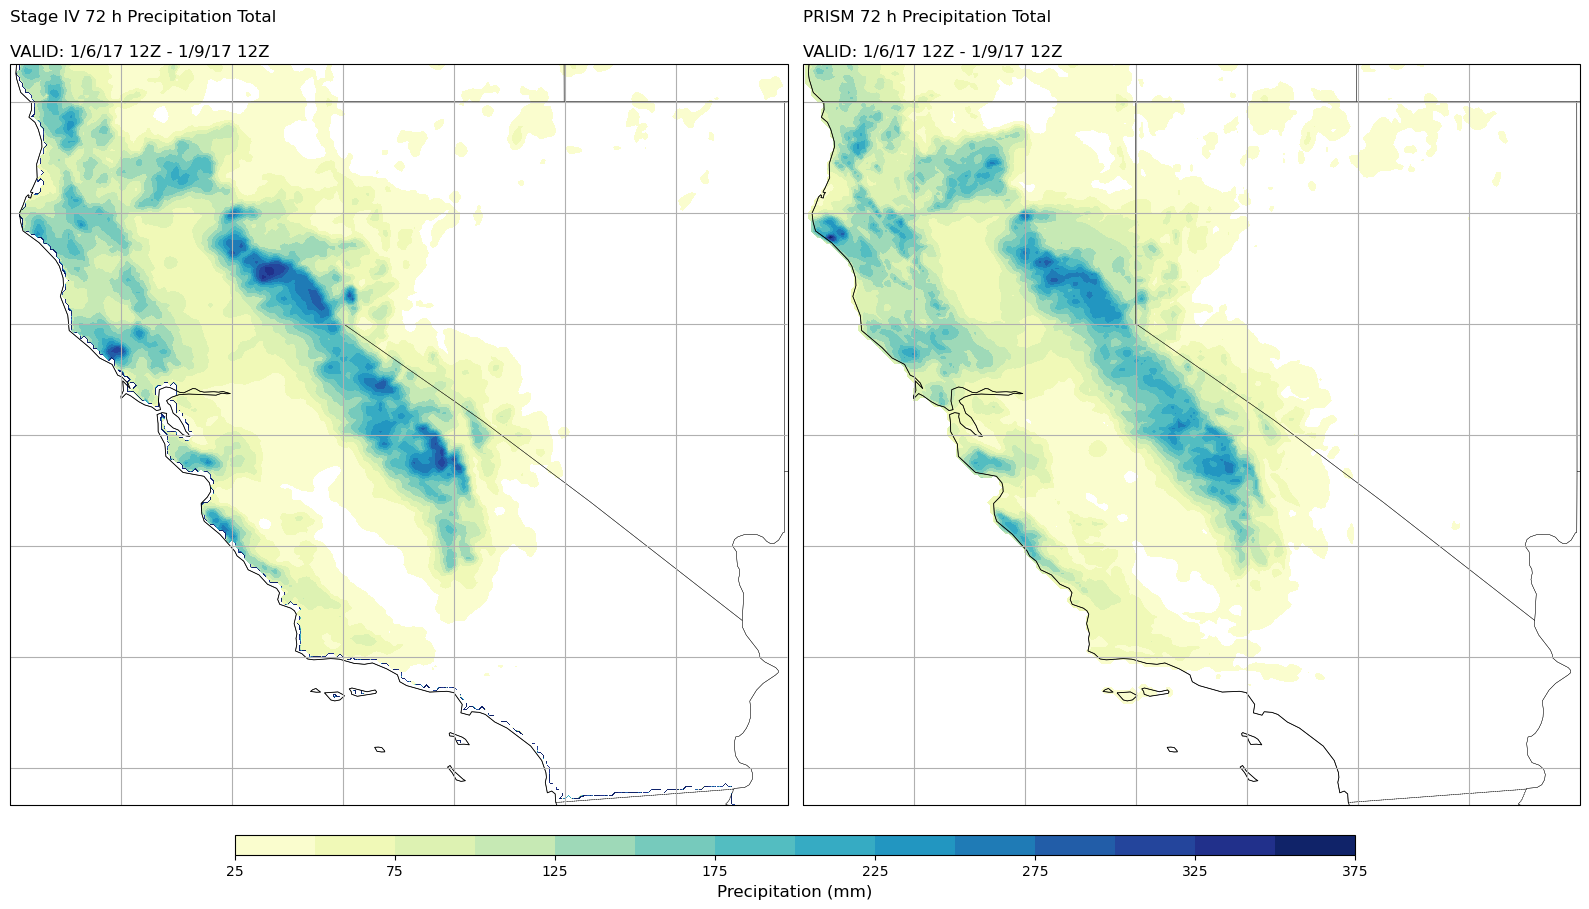

In [13]:
# Set limits for latitude and longitude to focus on California
# Rough bounds: (32.5 to 42 N) and (-124.5 to -114 W)
lat_min, lat_max = 32.5, 42.5
lon_min, lon_max = -124.5, -114

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})

for axs in ax:
    axs.set_extent([lon_min, lon_max, lat_min, lat_max])
    axs.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='black')
    axs.coastlines('50m', linewidth=0.6, color='black')
    axs.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)

    gl = axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False  # suppress top labels
    gl.bottom_labels = False
    gl.right_labels = False 
    gl.left_labels = False

contours = ax[0].contourf(to_np(lon_prism), to_np(lat_prism), stageiv_data, cmap='YlGnBu', levels=np.arange(25, 400, 25), transform=ccrs.PlateCarree())
#pcontours = ax[1].contourf(to_np(plons), to_np(plats), storm_total, cmap='YlGnBu', levels=np.arange(25, 400, 25), transform=ccrs.PlateCarree())
pcontours = ax[1].contourf(to_np(lon_prism), to_np(lat_prism), prism_storm_total, cmap='YlGnBu', levels=np.arange(25, 400, 25), transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = plt.colorbar(contours, cax=cbar_ax, orientation="horizontal", pad=.03, shrink=.8, aspect=50)
cbar.set_label("Precipitation (mm)", fontsize = 12)


# Create separate plot file and save as .png, then show and close
# Titles
ax[0].set_title('Stage IV 72 h Precipitation Total \n\nVALID: 1/6/17 12Z - 1/9/17 12Z',loc='left')
ax[1].set_title('PRISM 72 h Precipitation Total \n\nVALID: 1/6/17 12Z - 1/9/17 12Z',loc='left')
plt.tight_layout()
plt.savefig('prism_stageiv_comp')
plt.show()

In [14]:
diff_fields = prism_storm_total- stageiv_data

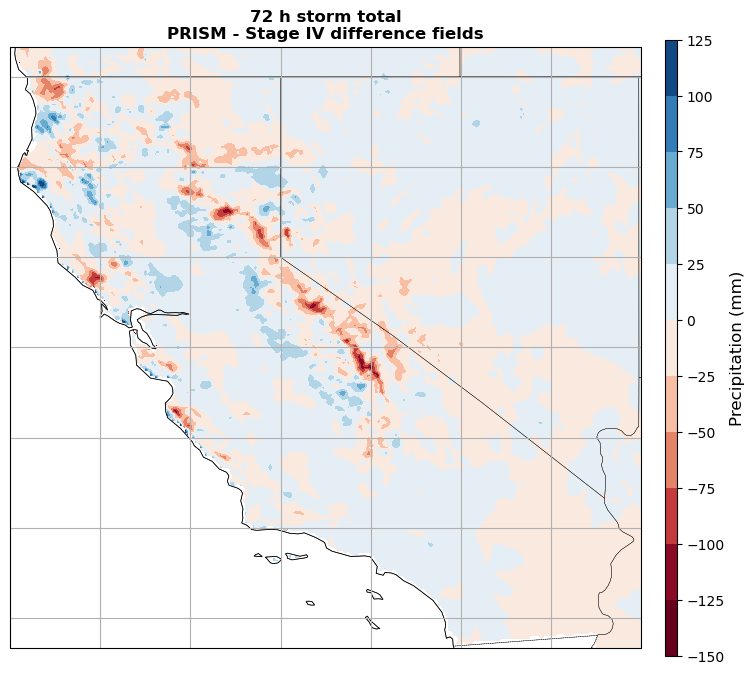

In [21]:
# Set limits for latitude and longitude to focus on California
# Rough bounds: (32.5 to 42 N) and (-124.5 to -114 W)
lat_min, lat_max = 32.5, 42.5
lon_min, lon_max = -124.5, -114
levels =np.arange(-150, 150, 25)

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='black')
ax.coastlines('50m', linewidth=0.6, color='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False # suppress top labels
gl.bottom_labels=False
gl.right_labels=False 
gl.left_labels=False

contours = plt.contourf(to_np(lon_prism), to_np(lat_prism), diff_fields, cmap='RdBu', levels=levels,vmin=-125,vmax=125, transform=ccrs.PlateCarree())
cbar = plt.colorbar(contours, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
cbar.set_label("Precipitation (mm)", fontsize = 12)
cbar.set_ticks(levels)
ax.set_title('72 h storm total\nPRISM - Stage IV difference fields', fontweight='bold')
# Create separate plot file and save as .png, then show and close
# Titles
fig.tight_layout()
plt.savefig('Prism_stageiv_diff')
plt.show()